# Introduction Bayesian Linear Regression Project
In this notebook, we will implement a complete machine learning project, focusing on bayesian inference method, in particular, Bayesian Linear Regression. We will go through the entire machine learning process, cleaning the data, exploring it to find trends, establishing a baseline model, evaluating several machine learning approaches for comparisons, implementing Bayesian Linear Regression, interpreting the results, and presenting the results. Let's get started.

## Dataset
We are using data on student grades collected from a Portugese secondary (high) school. This data is from the _[UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/student+performance)_, a great collection of datasets for model testing. The data includes academic and personal characteristics of the students as well as final grades. The objective is to predict the final grade form the student information which makes this a supervised, regression task. We have a set of training data with known labels, and we want the model to learn a mapping from the features (explanatory variables) to the target (the label) in this case the final grade. It is the regression task because the final grades is a continuous value.

# Exploratory Data Analysis

In [1]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np
np.random.seed(42)

 
# Matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['figure.figsize'] = (9,6)

import seaborn as sns

from IPython.core.pylabtools import figsize

# Scipy helper functions
from scipy.stats import percentileofscore
from scipy import stats

In [2]:
# Standard ML Models for comparisons
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

# Splitting data into training and testing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error

# Distributions
import scipy

In [3]:
# PyMC3 for Bayesian Inference
import pymc3 as pm

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\Asus\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Read in data and examine

In [4]:
# Read in class scores
df = pd.read_csv('data/student.csv')

# Filter out grades that were 0
df = df[~df['G3'].isin([0,1])]
df = df.rename(columns = {'G3': 'Grade'})

df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,Grade
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


In [5]:
df.shape

(633, 33)

## Describe the numerical columns

In [6]:
df.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,Grade
count,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000
mean,16.720379,2.519747,2.320695,1.563981,1.941548,0.206951,3.932070,3.169036,3.184834,1.489731,2.268562,3.527646,3.751975,11.503949,11.756714,12.205371
std,1.214044,1.133497,1.102284,0.750167,0.833284,0.579023,0.946411,1.047082,1.162014,0.912452,1.281776,1.448355,4.662003,2.682645,2.629715,2.656882
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,5.000000,5.000000
25%,16.000000,2.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,2.000000,0.000000,10.000000,10.000000,10.000000
50%,17.000000,2.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,11.000000,12.000000,12.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,6.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,32.000000,19.000000,19.000000,19.000000


## Value counts for Categorical columns

In [7]:
# Print the value counts for categorical columns
for col in df.columns:
    if df[col].dtype == 'object':
        print('\nColumn Name: ', col,)
        print(df[col].value_counts())


Column Name:  school
GP    421
MS    212
Name: school, dtype: int64

Column Name:  sex
F    376
M    257
Name: sex, dtype: int64

Column Name:  address
U    446
R    187
Name: address, dtype: int64

Column Name:  famsize
GT3    443
LE3    190
Name: famsize, dtype: int64

Column Name:  Pstatus
T    555
A     78
Name: Pstatus, dtype: int64

Column Name:  Mjob
other       249
services    135
at_home     131
teacher      70
health       48
Name: Mjob, dtype: int64

Column Name:  Fjob
other       359
services    175
at_home      41
teacher      35
health       23
Name: Fjob, dtype: int64

Column Name:  reason
course        279
home          146
reputation    141
other          67
Name: reason, dtype: int64

Column Name:  guardian
mother    444
father    149
other      40
Name: guardian, dtype: int64

Column Name:  schoolsup
no     566
yes     67
Name: schoolsup, dtype: int64

Column Name:  famsup
yes    393
no     240
Name: famsup, dtype: int64

Column Name:  paid
no     595
yes     38
Nam

### Distribution of Grades

In [8]:
df['Grade'].describe()

count    633.000000
mean      12.205371
std        2.656882
min        5.000000
25%       10.000000
50%       12.000000
75%       14.000000
max       19.000000
Name: Grade, dtype: float64

In [9]:
df['Grade'].value_counts()

11    104
10     97
13     82
12     72
14     63
15     49
16     36
9      35
8      35
17     29
18     15
7      10
6       3
19      2
5       1
Name: Grade, dtype: int64

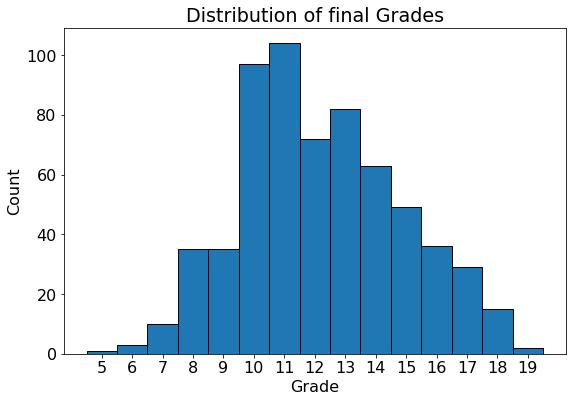

In [10]:
# Bar plot of Grades
plt.bar(df['Grade'].value_counts().index,
       df['Grade'].value_counts().values,
       fill = 'navy', edgecolor = 'k', width = 1)
plt.xlabel('Grade'); plt.ylabel('Count'); plt.title('Distribution of final Grades');
plt.xticks(list(range(5, 20)));

The Grade are close to normally distributed with a mode at 11 and mean at 12.20 (the grading in this school goes from 0-20). While the overall grades do not have a noticeable skew, it's possible that students from certain categories will have skewed grades. To look at the effect of categorical variables on the grade we can make density plots of the grade distribution colored by te value of the categorical variable. For this we use the seaborn library and the kdeplot function.

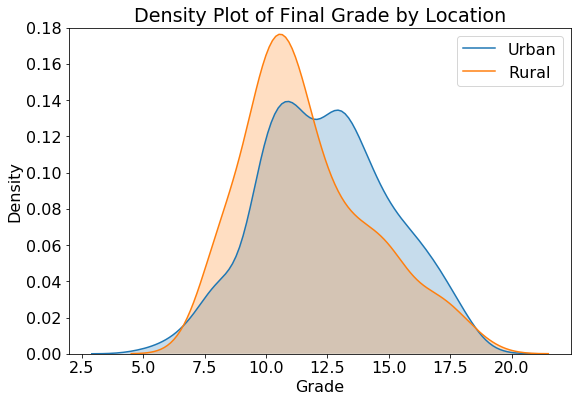

In [11]:
# Grade distibution by address
sns.kdeplot(df.loc[df['address'] == 'U', 'Grade'], label = 'Urban', shade = True)
sns.kdeplot(df.loc[df['address'] == 'R', 'Grade'], label = 'Rural', shade = True)
plt.xlabel('Grade'); plt.ylabel('Density'); plt.title('Density Plot of Final Grade by Location');
plt.ylim(0, .18);

(0, 0.21)

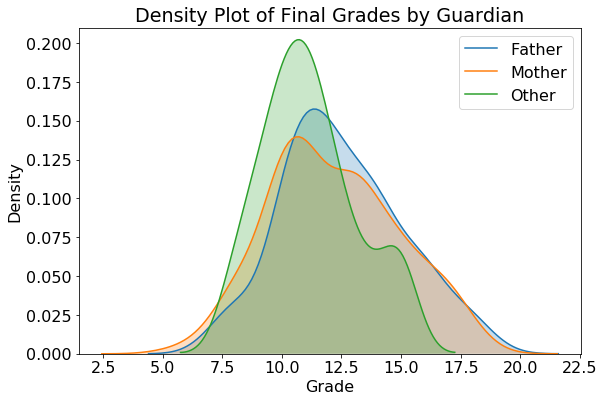

In [12]:
# Grade distribution by Guardian
sns.kdeplot(df.loc[df['guardian'] == 'father', 'Grade'], label = 'Father', shade = True)
sns.kdeplot(df.loc[df['guardian'] == 'mother', 'Grade'], label = 'Mother', shade = True)
sns.kdeplot(df.loc[df['guardian'] == 'other', 'Grade'], label = 'Other', shade = True)
plt.xlabel('Grade'); plt.ylabel('Density'); plt.title('Density Plot of Final Grades by Guardian');
plt.ylim(0,.21)

The actual values on a density plot are difficult to interpret, but we can use the shape of the plots for comparisons. The location does not seem to have a substantial impact on the student grades and neither does the guardian. Plots such as this can inform our modeling because they tell us if knowing the location or the guardian might be helpful for predicting the final grades. Of course we want to use a measure more rigorous than a single plot to make these conclusions, and later we will use statistics to back up our intuitions! For competion, let's check another categorical variables.

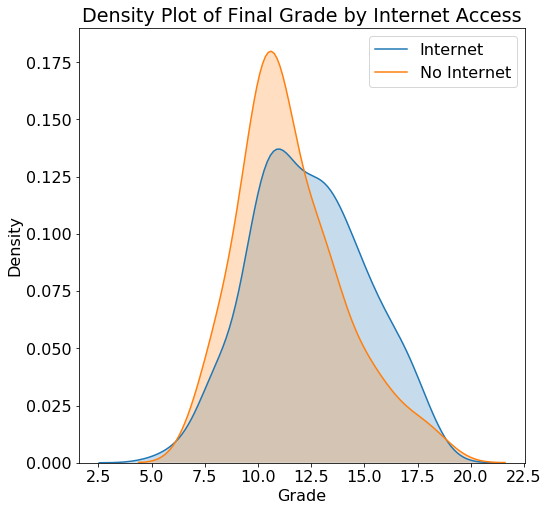

In [13]:
# Grade distribution by internet
figsize(8,8)

sns.kdeplot(df.loc[df['internet'] == 'yes', 'Grade'], label = 'Internet', shade = True)
sns.kdeplot(df.loc[df['internet'] == 'no', 'Grade'], label = 'No Internet', shade = True)
plt.xlabel('Grade'); plt.ylabel('Density'); plt.title('Density Plot of Final Grade by Internet Access');
plt.ylim(0, .19);

(0, 0.17)

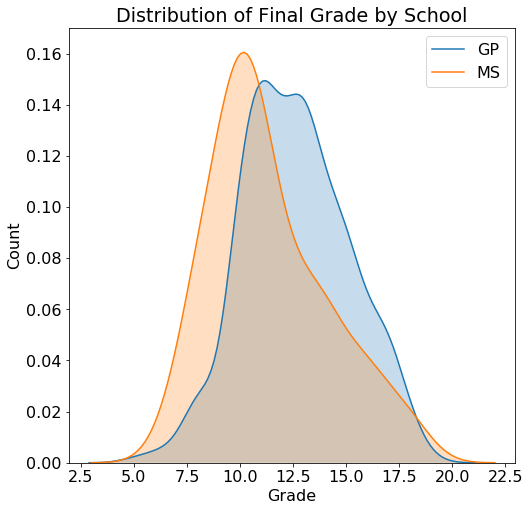

In [14]:
# Grade distribution by school
sns.kdeplot(df.loc[df['school'] == 'GP', 'Grade'], label = 'GP', shade = True)
sns.kdeplot(df.loc[df['school'] == 'MS', 'Grade'], label = 'MS', shade = True)
plt.xlabel('Grade'); plt.ylabel('Count'); plt.title('Distribution of Final Grade by School');
plt.ylim(0, 0.17)

In [15]:
# Look of distribution of schools by address
schools = df.groupby(['school'])['address'].value_counts()
schools

school  address
GP      U          343
        R           78
MS      R          109
        U          103
Name: address, dtype: int64

## Grade Percentiles

In [16]:
# Calculate percentile for grades
df['percentile'] = df['Grade'].apply(lambda x: percentileofscore(df['Grade'], x))

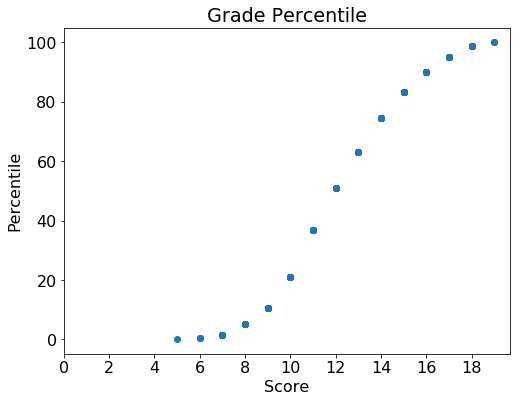

In [17]:
# Plot percentile for Grade
plt.figure(figsize = (8,6))
plt.plot(df['Grade'], df['percentile'], 'o')
plt.xticks(range(0, 20, 2), range(0, 20, 2))
plt.xlabel('Score'); plt.ylabel('Percentile'); plt.title('Grade Percentile');

## Feature Selection
As we saw from the plots, we don't expect every variable to be related to the final grade, so we need perform feature selection (also called dimensionality reduction) to choose only the "relevant" variables. This depends on the problem, but because we will be doing linear modeling in this project, we can use a simple measure called Correlation Coefficient to determine the most useful variables for predicting the grade. this is a value between -1 and +1 that measures the direction and strength of a linear relationship between two variables.

To select a limited number of variables, we can find those that have the greates correlation (either negative or positive) with the final grade.

## Variable Correlations with Final Grade

### Numerical correlations

In [18]:
# Correlation of numerical values
df.corr()['Grade'].sort_values()

failures     -0.384569
absences     -0.204230
Dalc         -0.196891
Walc         -0.178839
traveltime   -0.129654
goout        -0.111228
freetime     -0.105206
health       -0.096461
age          -0.042505
famrel        0.072888
Fedu          0.204392
studytime     0.249855
Medu          0.278690
G1            0.874777
G2            0.942691
percentile    0.985253
Grade         1.000000
Name: Grade, dtype: float64

These correlations seems to make sense at least by my rudimentary social knowledge! Failures is the number of previous class failures and is negatively correlated with the grade, as is absences, the number of absences from school. These negative correlation indicate that as this variables increase, the final grade tends to decrease (although we can only say this is a correlation and not that one variable cause another to decrease). On the other hand, both the studytime, the amount for studying per week, and medu, the mother's level of education, are positively correlated with the grade.

Correlations can only be calculated between numerical variables, so to find the relationship between categorical variables and then calculate the correalation coeficient. One-hot encoding is a process that creates one column for every category within a categorical variable.

### Categorical Correlations using One-Hot Encoding

In [19]:
# Select only categorical variables
category_df = df.select_dtypes('object')

# one hot encode the variables
dummy_df = pd.get_dummies(category_df)

# Put the grade back in the dataframe
dummy_df['Grade'] = df['Grade']
dummy_df.head()

,school_GP,school_MS,sex_F,sex_M,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,Pstatus_T,...,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes,Grade
0,1,0,1,0,0,1,1,0,1,0,...,0,0,1,0,1,1,0,1,0,11
1,1,0,1,0,0,1,1,0,0,1,...,0,1,0,0,1,0,1,1,0,11
2,1,0,1,0,0,1,0,1,0,1,...,0,0,1,0,1,0,1,1,0,12
3,1,0,1,0,0,1,1,0,0,1,...,1,0,1,0,1,0,1,0,1,14
4,1,0,1,0,0,1,1,0,0,1,...,0,0,1,0,1,1,0,1,0,13


In [20]:
# Correlations in one-hot encoded dataframe
dummy_df.corr()['Grade'].sort_values()

higher_no           -0.343742
school_MS           -0.227632
Mjob_at_home        -0.158496
reason_course       -0.138195
internet_no         -0.131408
address_R           -0.128350
sex_M               -0.125755
guardian_other      -0.100802
schoolsup_yes       -0.098185
reason_other        -0.092382
activities_no       -0.078526
paid_yes            -0.067146
nursery_no          -0.056449
romantic_yes        -0.052050
Fjob_at_home        -0.049372
Fjob_services       -0.042497
Mjob_other          -0.035494
Fjob_other          -0.021292
famsize_GT3         -0.012957
guardian_mother     -0.008042
Pstatus_T           -0.001776
famsup_no           -0.001581
famsup_yes           0.001581
Pstatus_A            0.001776
Mjob_services        0.006210
famsize_LE3          0.012957
Fjob_health          0.026320
reason_home          0.046639
romantic_no          0.052050
nursery_yes          0.056449
guardian_father      0.066486
paid_no              0.067146
activities_yes       0.078526
Mjob_healt

We again see relationships that intuitively make sense: higher_no represents the student does not want to go on to higher education and is negatively correlated with the grade with higher_yes indicating the student does want higher education and showing a positive correlation. Mjob_at_home means the mother stays at home, and is negatively correlated with the grade while Mjob_teacher indicates the mother teaches and has a positive correlation.

In this problem we will use these results to perform feature selection by retaining only 6 variables that are most highly correlated with the final grade. 6 is sort of an arbitrary number that I found works well in the model, which shows that a lot pf machine learning is just experimentation!

## Select Most Correlated Variables with final score

In [21]:
# Takes in  a dataframe, finds the most correlated variables with the
# grade and returns training and testing datasets
def format_data(df):
    # Targets are final grade of student
    labels = df['Grade']
    
    # Drop the  school and the grades from features
    df = df.drop(columns = ['school', 'G1', 'G2', 'percentile'])
    
    # One hot encoding of Categorical Variables
    df = pd.get_dummies(df)
    
    # Find Correlations with the grade
    most_correlated = df.corr().abs()['Grade'].sort_values(ascending = False)
    
    # Maintain the top 6 most correlation features with Grade
    most_correlated = most_correlated[:8]
    
    df = df.loc[:, most_correlated.index]
    df = df.drop(columns = 'higher_no')
    
    # Split into training/testing sets with 25% split
    X_train, X_test, y_train, y_test = train_test_split(df, labels, test_size = 0.25, random_state = 42)
    
    return X_train, X_test, y_train, y_test

In [24]:
X_train, X_test, y_train, y_test = format_data(df)
X_train.head()

,Grade,failures,higher_yes,Medu,studytime,Fedu,absences
619,13,0,1,3,2,3,6
323,10,0,1,4,1,3,0
201,16,0,1,2,2,1,0
410,17,0,1,2,2,2,0
426,11,0,1,3,1,3,4


### Rename Variables

In [25]:
# Rename variables in train and test
X_train = X_train.rename(columns = {'higher_yes': 'higher_edu',
                                   'Medu': 'mother_edu',
                                   'Fedu': 'father_edu'})
X_test = X_test.rename(columns = {'higher_yes': 'higher_edu',
                                   'Medu': 'mother_edu',
                                   'Fedu': 'father_edu'})

### The Final six variables we end up with after feature selection

In [26]:
X_train.head()

,Grade,failures,higher_edu,mother_edu,studytime,father_edu,absences
619,13,0,1,3,2,3,6
323,10,0,1,4,1,3,0
201,16,0,1,2,2,1,0
410,17,0,1,2,2,2,0
426,11,0,1,3,1,3,4


In [27]:
print(X_train.shape)
print(X_test.shape)

(474, 7)
(159, 7)


The comlplete descriptions of the variables are on the UCI Machine Larning repository, but here is a brief overview:

- failures: previous class failures
- higher_edu: binary for whether the student will pursue higher education
- mother_edu: Mother's level of education
- studytime: amount of studying per week
- father_edu: Father's level of education
- absences: absences from school in the semester

While we are performing feature selection, we also split the data into a training and testing set using a Scikit-learn function. This is necessary because we need to have a hold-out test set to evaluate our model and make sure it is not overfitting to the testing data.

## Examine selected features with pairs plot

C:\Users\Asus\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Asus\Anaconda3\lib\site-packages\matplotlib\contour.py:1480: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
C:\Users\Asus\Anaconda3\lib\site-packages\matplotlib\contour.py:1481: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
C:\Users\Asus\Anaconda3\lib\site-packages\matplotlib\contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
C:\Users\Asus\Anaconda3\lib\site-packages\matplotlib\contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


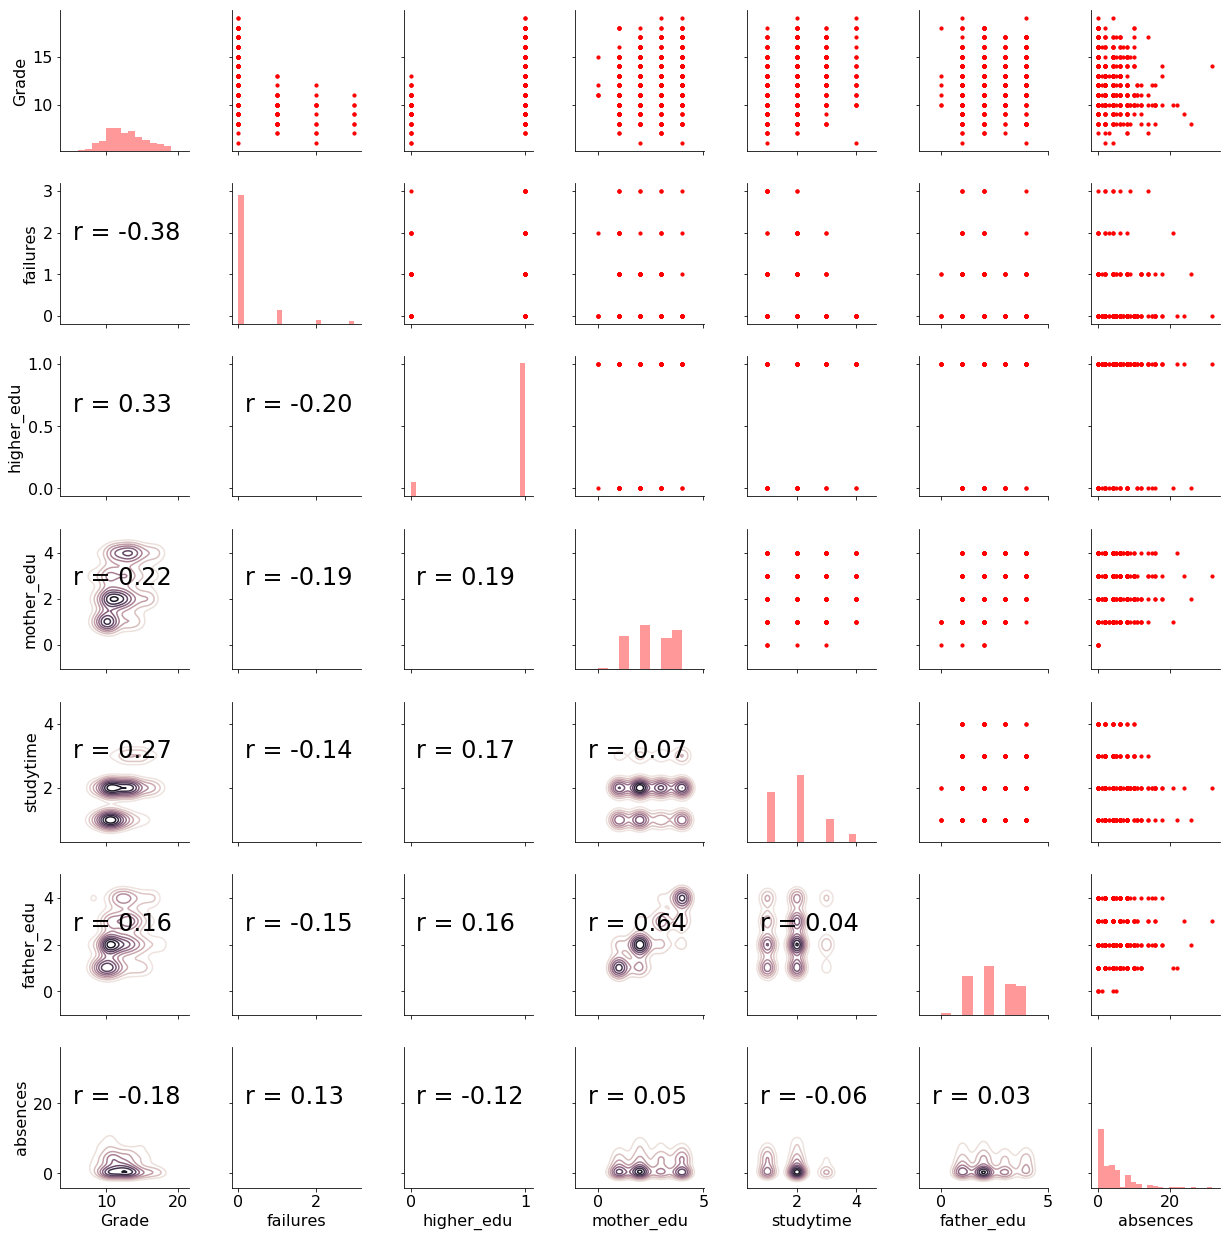

In [34]:
# Calculate correlation coefficient
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .6), xycoords=ax.transAxes,
               size = 24)
    
cmap = sns.cubehelix_palette(light=1, dark = 0.1,
                             hue = 0.5, as_cmap=True)

sns.set_context(font_scale=2)

# Pair grid set up
g = sns.PairGrid(X_train)

# Scatter plot on the upper triangle
g.map_upper(plt.scatter, s=10, color = 'red')

# Distribution on the diagonal
g.map_diag(sns.distplot, kde=False, color = 'red')

# Density Plot and Correlation coefficients on the lower triangle
g.map_lower(sns.kdeplot, cmap = cmap)
g.map_lower(corrfunc);